In [121]:
import numpy as np
import functools
import math
from matplotlib import collections as mc
import xml.etree.ElementTree as ET
from collections import namedtuple
import csv
import pprint


In [122]:
class Node:
    def __init__(self, node_id, node_type, cx, cy):
        self.node_id = node_id
        self.node_type = node_type
        self.cx = cx
        self.cy = cy

In [123]:
@functools.lru_cache(maxsize=None)
def distance_function(v1, v2):
    return math.sqrt(((v1.x - v2.x) * (v1.x - v2.x)) + ((v1.y - v2.y) * (v1.y - v2.y)))

In [124]:
# Load the XML file
tree = ET.parse('./data_32.xml')
root = tree.getroot()

# Extract information
dataset = root.find('./info/dataset').text
name = root.find('./info/name').text

print("Dataset:", dataset)
print("Name:", name)

print("Nodes:")
for node in root.findall('./network/nodes/node'):
    node_id = node.attrib['id']
    node_type = node.attrib['type']
    cx = node.find('cx').text
    cy = node.find('cy').text
    print(f"Node {node_id}: Type {node_type}, cx {cx}, cy {cy}")


Dataset: Augerat 1995 — Set A
Name: A-n32-k05
Nodes:
Node 1: Type 0, cx 82.0, cy 76.0
Node 2: Type 1, cx 96.0, cy 44.0
Node 3: Type 1, cx 50.0, cy 5.0
Node 4: Type 1, cx 49.0, cy 8.0
Node 5: Type 1, cx 13.0, cy 7.0
Node 6: Type 1, cx 29.0, cy 89.0
Node 7: Type 1, cx 58.0, cy 30.0
Node 8: Type 1, cx 84.0, cy 39.0
Node 9: Type 1, cx 14.0, cy 24.0
Node 10: Type 1, cx 2.0, cy 39.0
Node 11: Type 1, cx 3.0, cy 82.0
Node 12: Type 1, cx 5.0, cy 10.0
Node 13: Type 1, cx 98.0, cy 52.0
Node 14: Type 1, cx 84.0, cy 25.0
Node 15: Type 1, cx 61.0, cy 59.0
Node 16: Type 1, cx 1.0, cy 65.0
Node 17: Type 1, cx 88.0, cy 51.0
Node 18: Type 1, cx 91.0, cy 2.0
Node 19: Type 1, cx 19.0, cy 32.0
Node 20: Type 1, cx 93.0, cy 3.0
Node 21: Type 1, cx 50.0, cy 93.0
Node 22: Type 1, cx 98.0, cy 14.0
Node 23: Type 1, cx 5.0, cy 42.0
Node 24: Type 1, cx 42.0, cy 9.0
Node 25: Type 1, cx 61.0, cy 62.0
Node 26: Type 1, cx 9.0, cy 97.0
Node 27: Type 1, cx 80.0, cy 55.0
Node 28: Type 1, cx 57.0, cy 69.0
Node 29: Type 1,

In [125]:
print("\nFleet:")
for vehicle_profile in root.findall('./fleet/vehicle_profile'):
    departure_node = vehicle_profile.find('departure_node').text
    arrival_node = vehicle_profile.find('arrival_node').text
    capacity = vehicle_profile.find('capacity').text
    print(f"Departure Node: {departure_node}, Arrival Node: {arrival_node}, Capacity: {capacity}")


Fleet:
Departure Node: 1, Arrival Node: 1, Capacity: 100.0


In [126]:

print("\nRequests:")
for request in root.findall('./requests/request'):
    request_id = request.attrib['id']
    node = request.attrib['node']
    quantity = request.find('quantity').text
    print(f"Request ID: {request_id}, Node: {node}, Quantity: {quantity}")


Requests:
Request ID: 1, Node: 2, Quantity: 19.0
Request ID: 2, Node: 3, Quantity: 21.0
Request ID: 3, Node: 4, Quantity: 6.0
Request ID: 4, Node: 5, Quantity: 19.0
Request ID: 5, Node: 6, Quantity: 7.0
Request ID: 6, Node: 7, Quantity: 12.0
Request ID: 7, Node: 8, Quantity: 16.0
Request ID: 8, Node: 9, Quantity: 6.0
Request ID: 9, Node: 10, Quantity: 16.0
Request ID: 10, Node: 11, Quantity: 8.0
Request ID: 11, Node: 12, Quantity: 14.0
Request ID: 12, Node: 13, Quantity: 21.0
Request ID: 13, Node: 14, Quantity: 16.0
Request ID: 14, Node: 15, Quantity: 3.0
Request ID: 15, Node: 16, Quantity: 22.0
Request ID: 16, Node: 17, Quantity: 18.0
Request ID: 17, Node: 18, Quantity: 19.0
Request ID: 18, Node: 19, Quantity: 1.0
Request ID: 19, Node: 20, Quantity: 24.0
Request ID: 20, Node: 21, Quantity: 8.0
Request ID: 21, Node: 22, Quantity: 12.0
Request ID: 22, Node: 23, Quantity: 4.0
Request ID: 23, Node: 24, Quantity: 8.0
Request ID: 24, Node: 25, Quantity: 24.0
Request ID: 25, Node: 26, Quant

In [127]:
def fitness_function(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:] + solution[0:1]):
        solution_distance += distance(vertices[x], vertices[y])
    
    return solution_distance

In [128]:
def initialize_pheromone(N):
    return 0.01 * np.ones(shape=(N,N))


def update_pheromone(pheromones_array, solutions, fitness_values, Q, rho):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fitness_value in zip(solutions, fitness_values):
        for x, y in zip(solution, solution[1:] + solution[0:1]):
            pheromone_update[x, y] += Q / fitness_value
    
    return (1 - rho) * pheromones_array + pheromone_update

In [129]:
def generate_solutions(vertices, pheromones, distance_function, number_of_ants, alpha=1, beta=3):
    
    # Probability of selecting v2 right after v1
    def compute_prob(v1, v2):
        inverse_distance = 1 / distance_function(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(inverse_distance, beta)
        return ret if ret > 1e-6 else 1e-6

    number_of_vertices = len(vertices)
    for _ in range(number_of_ants):
        available = list(range(number_of_vertices))
        solution = [np.random.randint(0, number_of_vertices)]
        available.remove(solution[0])
        
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=(probs / np.sum(probs))) # Edge selection
            solution.append(selected)
            available.remove(selected)
            
        yield solution

In [130]:
def ant_solver(vertices, distance_function, number_of_ants=10, max_iterations=1000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float("inf")
    log_of_best_distances = list()
    
    print("Iteration\tMinimum value\tMean value\tMaximum value")
    
    for i in range(max_iterations):
        candidate_solutions = list(generate_solutions(vertices, pheromones, distance_function, number_of_ants, alpha=alpha, beta=beta))
        fitness_values = list(map(lambda x: fitness_function(vertices, distance_function, x), candidate_solutions))
        pheromones = update_pheromone(pheromones, candidate_solutions, fitness_values, Q=Q, rho=rho)
        
        for candidate_solution, fitness_value in zip(candidate_solutions, fitness_values):
            if fitness_value < best_fitness:
                best_fitness = fitness_value
                best_solution = candidate_solution
                
        log_of_best_distances.append(np.min(fitness_values))
        
        print(f"{i:8}:\t{np.min(fitness_values):5.8f}\t{np.mean(fitness_values):5.8f}\t{np.max(fitness_values):5.8f}")
    return best_solution, pheromones, log_of_best_distances

In [131]:
Vertex = namedtuple("Vertex", ["name", "x", "y"])

vertices = []
with open("cities.csv") as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

Iteration	Minimum value	Mean value	Maximum value
       0:	290.06189048	361.44273664	468.05340326
       1:	283.83501150	313.11220739	356.07215039
       2:	257.41666958	290.71992996	340.77271365
       3:	259.92915172	288.99955651	334.21503574
       4:	245.34887407	264.82641863	283.15774624


       5:	242.11799234	273.09016222	311.21174327
       6:	255.24881918	281.99299109	335.40278564
       7:	259.40880547	287.43200141	330.88106845
       8:	244.86128079	278.66656027	315.05332046
       9:	254.74859362	280.34562643	317.06817915
      10:	241.59149792	288.07632418	327.88497278
      11:	245.94520172	280.29517173	351.54242143
      12:	234.10341593	260.50676021	306.84839436
      13:	240.43842536	273.34104952	311.71806224
      14:	242.84983029	278.94387412	318.09283801
      15:	253.67652627	286.92237521	319.99274411
      16:	244.44109770	279.35664964	307.09102901
      17:	244.44109770	275.99368763	320.22875625
      18:	263.50967919	291.09973336	320.65903099
      19:	263.15797393	306.71894119	356.10393566
      20:	258.77637328	300.68629113	361.24442094
      21:	244.44109770	273.19657193	300.97219803
      22:	237.70333458	274.77355381	331.86324515
      23:	244.44109770	270.43327951	326.80866860
      24:	242.09403290	252.93936465	271.13007910
      25:	244.441097

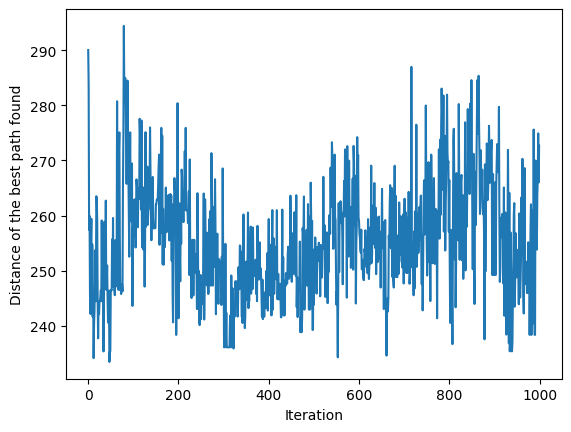

In [132]:
from matplotlib import pyplot as plt


best_solution, pheromones, log_of_best_distances = ant_solver(vertices, distance_function)

plt.plot(log_of_best_distances)
plt.ylabel("Distance of the best path found")
plt.xlabel("Iteration")
plt.show()

Fitness:  233.41171439333138


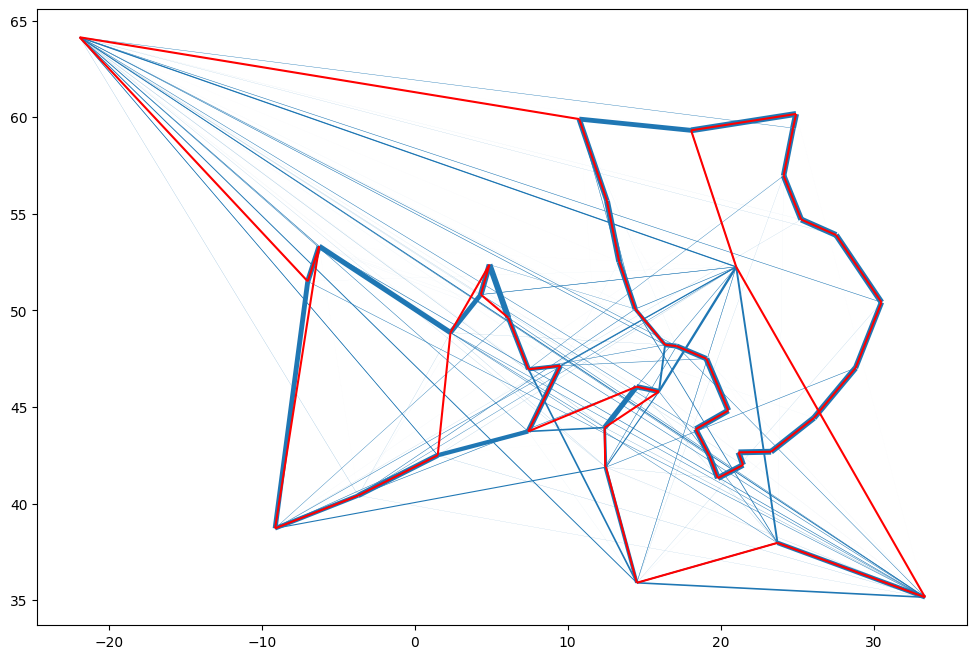

[Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Madrid', x=-3.7, y=40.41666667),
 Vertex(name='Lisbon', x=-9.133333333, y=38.71666667),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='London', x=-7.0, y=51.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Oslo', x=10.75, y=59.9),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Vienna', x=16.36666667,

In [133]:
# Render pheromones (blue, line width corresponds to the pheromon value on the edge)
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i, j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# Here, you can test the influence of the individual parameters on the generated candidate solution
# solution = list(generate_solutions(vertices, pheromones, distance_function, number_of_ants=1, alpha=3, beta=1))[0]

# Print solution's fitness
print("Fitness: ", fitness_function(vertices, distance_function, solution))

# Render the solution (red)
solution_lines = []
for i, j in zip(solution, solution[1:] + solution[0:1]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

solutions_lc = mc.LineCollection(solution_lines, colors="red")

ax.add_collection(solutions_lc)

plt.show()

# Print towns in the order of the soultion
solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)